# Coinrun VAE Visualization

## Part I

**imports**

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import os
import yaml

**load and visualize training data**

In [7]:
# load data
obs = np.load('./dataset/data.npz')['obs']
obs = obs.astype(np.float32) / 255.0
print(obs.shape)

# aggregate data
dataset = obs.reshape(-1, *obs.shape[2:])
print(dataset.shape)

(400, 32, 64, 64, 3)
(12800, 64, 64, 3)


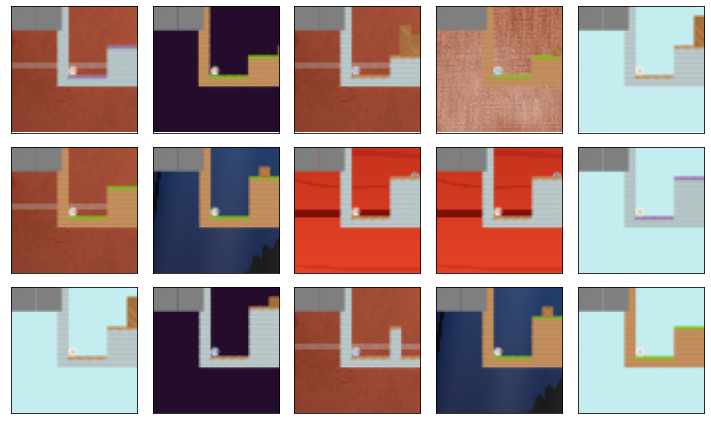

In [10]:
# visualize data
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(10, 6), subplot_kw={'xticks': [], 'yticks': []})

for ax in axs.flat:
    step = random.randint(0, obs.shape[0] - 1)
    env = random.randint(0, obs.shape[1] - 1)
    ax.imshow(obs[step][env])
plt.tight_layout()
plt.show()

**load trained VAE**

In [38]:
from models import *

with open('configs/bhvae.yaml', 'r') as file:
    try:
        config = yaml.safe_load(file)
    except yaml.YAMLError as exc:
        print(exc)

model = vae_models[config['model_params']['name']](**config['model_params'])
checkpoint = torch.load('logs/BetaVAE_H/version_1/checkpoints/_ckpt_epoch_0.ckpt', map_location=torch.device('cpu'))
cp = checkpoint['state_dict']
cp2 = {}
for k in cp:
    cp2[k[6:]] = cp
checkpoint['state_dict'] = cp2
model.load_state_dict(checkpoint)

#BetaVAE.load_from_checkpoint('logs/BetaVAE_H/version_1/checkpoints/_ckpt_epoch_0.ckpt')

RuntimeError: Error(s) in loading state_dict for BetaVAE:
	Missing key(s) in state_dict: "encoder.0.0.weight", "encoder.0.0.bias", "encoder.0.1.weight", "encoder.0.1.bias", "encoder.0.1.running_mean", "encoder.0.1.running_var", "encoder.1.0.weight", "encoder.1.0.bias", "encoder.1.1.weight", "encoder.1.1.bias", "encoder.1.1.running_mean", "encoder.1.1.running_var", "encoder.2.0.weight", "encoder.2.0.bias", "encoder.2.1.weight", "encoder.2.1.bias", "encoder.2.1.running_mean", "encoder.2.1.running_var", "encoder.3.0.weight", "encoder.3.0.bias", "encoder.3.1.weight", "encoder.3.1.bias", "encoder.3.1.running_mean", "encoder.3.1.running_var", "encoder.4.0.weight", "encoder.4.0.bias", "encoder.4.1.weight", "encoder.4.1.bias", "encoder.4.1.running_mean", "encoder.4.1.running_var", "fc_mu.weight", "fc_mu.bias", "fc_var.weight", "fc_var.bias", "decoder_input.weight", "decoder_input.bias", "decoder.0.0.weight", "decoder.0.0.bias", "decoder.0.1.weight", "decoder.0.1.bias", "decoder.0.1.running_mean", "decoder.0.1.running_var", "decoder.1.0.weight", "decoder.1.0.bias", "decoder.1.1.weight", "decoder.1.1.bias", "decoder.1.1.running_mean", "decoder.1.1.running_var", "decoder.2.0.weight", "decoder.2.0.bias", "decoder.2.1.weight", "decoder.2.1.bias", "decoder.2.1.running_mean", "decoder.2.1.running_var", "decoder.3.0.weight", "decoder.3.0.bias", "decoder.3.1.weight", "decoder.3.1.bias", "decoder.3.1.running_mean", "decoder.3.1.running_var", "final_layer.0.weight", "final_layer.0.bias", "final_layer.1.weight", "final_layer.1.bias", "final_layer.1.running_mean", "final_layer.1.running_var", "final_layer.3.weight", "final_layer.3.bias". 
	Unexpected key(s) in state_dict: "epoch", "global_step", "checkpoint_callback_best", "optimizer_states", "lr_schedulers", "state_dict". 

In [8]:
# load trained model
! aws s3 sync s3://nathan.experiments/adversarial_pixels ./s3
    
model_path = './s3/12Nov2020-13h16m02s/tmp_0_50800/batch_64/lr_0.0001/' \
             'z_size_64/beta_1.0/kl_tolerance_0.5/vanilla_/vae_ep_900.json'

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

vae = ConvVAE(z_size=64,
              batch_size=1,
              is_training=False,
              reuse=False,
              gpu_mode=False)

vae.load_json_full(model_path)
print(dir(vae))

INFO:tensorflow:Model using cpu.
conv_vae/enc_conv1/kernel:0
conv_vae/enc_conv1/bias:0
conv_vae/enc_conv2/kernel:0
conv_vae/enc_conv2/bias:0
conv_vae/enc_conv3/kernel:0
conv_vae/enc_conv3/bias:0
conv_vae/enc_conv4/kernel:0
conv_vae/enc_conv4/bias:0
conv_vae/enc_fc_mu/kernel:0
conv_vae/enc_fc_mu/bias:0
conv_vae/enc_fc_log_var/kernel:0
conv_vae/enc_fc_log_var/bias:0
conv_vae/dec_fc/kernel:0
conv_vae/dec_fc/bias:0
conv_vae/dec_deconv1/kernel:0
conv_vae/dec_deconv1/bias:0
conv_vae/dec_deconv2/kernel:0
conv_vae/dec_deconv2/bias:0
conv_vae/dec_deconv3/kernel:0
conv_vae/dec_deconv3/bias:0
conv_vae/dec_deconv4/kernel:0
conv_vae/dec_deconv4/bias:0
Loading parameter conv_vae/enc_conv1/kernel:0
Loading parameter conv_vae/enc_conv1/bias:0
Loading parameter conv_vae/enc_conv2/kernel:0
Loading parameter conv_vae/enc_conv2/bias:0
Loading parameter conv_vae/enc_conv3/kernel:0
Loading parameter conv_vae/enc_conv3/bias:0
Loading parameter conv_vae/enc_conv4/kernel:0
Loading parameter conv_vae/enc_conv4/

**visualize reconstructions and encodings**

(from left to right: original image, reconstructed image, z-image)

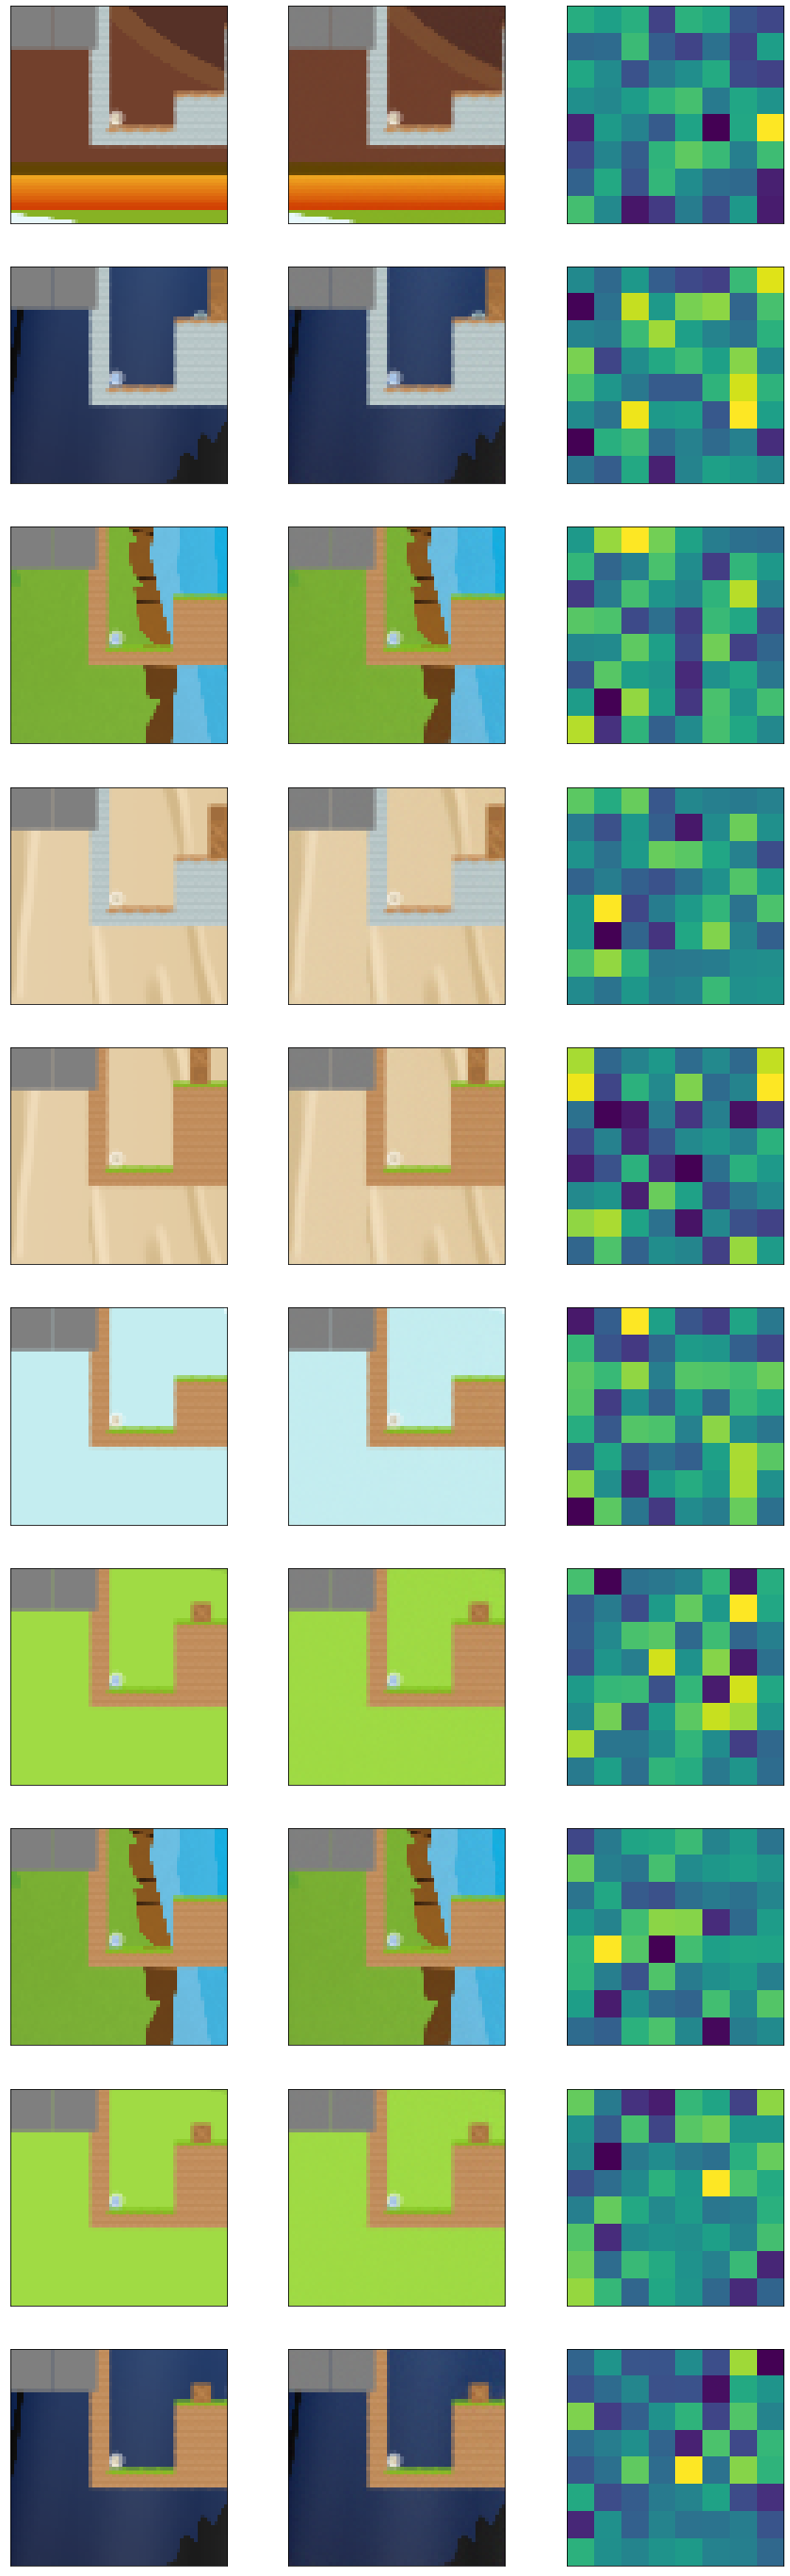

In [9]:
N = 10
assert N > 1

_, axs = plt.subplots(nrows=N, ncols=3, figsize=(15, 5 * N), subplot_kw={'xticks': [], 'yticks': []})

# encode/decode
for i in range(N):
    idx = random.randint(0, len(dataset) - 1)
    img = dataset[idx][np.newaxis, ...]
    img_z = vae.encode(img)
    img_r = vae.decode(img_z)

    axs[i][0].imshow(img[0])
    axs[i][1].imshow(img_r[0])
    axs[i][2].imshow(img_z.reshape(8, 8))

**some stats**

In [13]:
diffs_avg = []
diffs_std = []
all_z = []

for i in range(100):
    idx = random.randint(0, len(dataset) - 1)
    img = dataset[idx][np.newaxis, ...]
    img_z = vae.encode(img)
    img_r = vae.decode(img_z)

    diffs_avg.append(255 * np.mean(img - img_r))
    diffs_std.append(255 * np.std(img - img_r))
    
    all_z.append(img_z[0])
    
print(f'reconstruction error: avg={np.mean(diffs_avg)}, std={np.mean(diffs_std)}')
print('(for values ranging between 0 and 255)\n')

all_z = np.array(all_z)
print('z-domain means:')
print(np.round(np.mean(all_z, axis=0), decimals=2))
print('\nz-domain stds:')
print(np.round(np.std(all_z, axis=0), decimals=2))
print('\nz-domain mins:')
print(np.round(np.min(all_z, axis=0), decimals=2))
print('\nz-domain maxs:')
print(np.round(np.max(all_z, axis=0), decimals=2))

reconstruction error: avg=0.22203805614753946, std=1.284322531381622
(for values ranging between 0 and 255)

z-domain means:
[-0.17 -0.01 -0.12  0.    0.11 -0.12  0.07  0.1   0.11  0.18 -0.02 -0.13
  0.02  0.17  0.02  0.03 -0.04  0.11 -0.29  0.08 -0.09  0.06  0.08  0.28
 -0.05  0.16  0.01 -0.01 -0.1   0.04 -0.1   0.02 -0.01  0.19 -0.08  0.04
  0.03 -0.09 -0.07 -0.11 -0.11  0.15  0.07  0.11  0.1  -0.01  0.24 -0.16
  0.14 -0.02 -0.03 -0.19  0.02 -0.04 -0.06  0.05  0.13  0.02 -0.09 -0.17
  0.04  0.05  0.13 -0.14]

z-domain stds:
[1.   1.03 1.04 1.03 1.05 1.1  1.   1.1  0.95 1.1  1.02 0.97 1.02 1.11
 0.97 0.9  1.04 0.98 0.99 0.92 0.99 1.02 1.14 0.94 0.96 0.97 1.06 1.03
 0.94 1.03 0.96 0.99 0.78 0.91 0.96 0.88 0.88 1.02 0.95 1.   1.08 1.05
 0.85 0.98 1.04 0.96 1.06 1.09 1.18 0.97 1.03 0.94 0.91 0.87 0.91 1.09
 1.2  0.92 0.93 1.04 0.83 0.99 1.05 1.08]

z-domain mins:
[-2.66 -2.67 -2.32 -2.62 -2.08 -1.8  -2.21 -2.46 -1.9  -2.54 -2.56 -3.01
 -1.99 -3.54 -2.24 -2.21 -2.62 -2.23 -3.53 -2.12 -2.6

## Part 2

**visualize z-domain perturbation on 1 dimension**

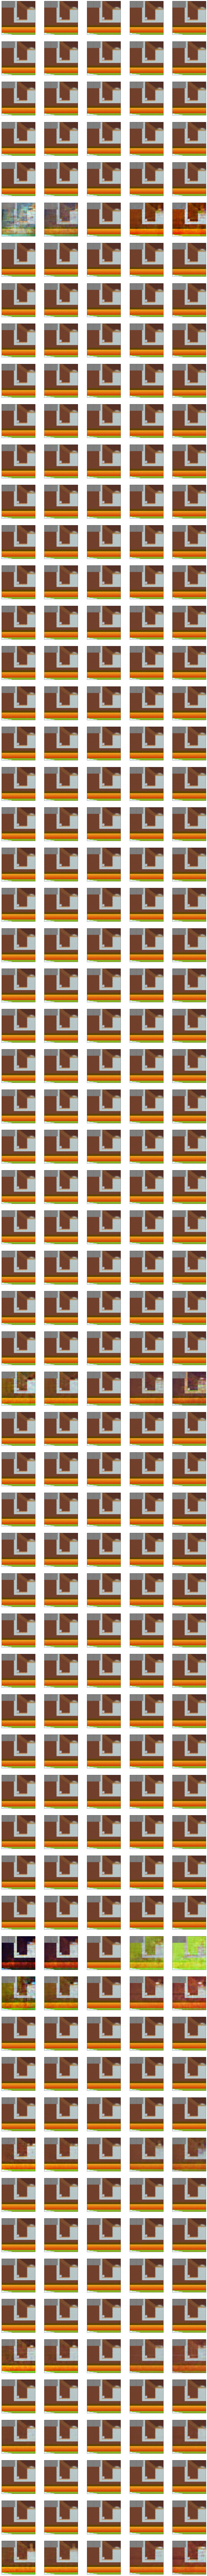

In [14]:
_, axs = plt.subplots(nrows=64, ncols=5, figsize=(25, 5 * 64), subplot_kw={'xticks': [], 'yticks': []})

idx = random.randint(0, len(dataset) - 1)
img = dataset[idx][np.newaxis, ...]
img_z = vae.encode(img)

# encode/decode
for dim in range(64):
    for j, delta in enumerate([-2, -1, 0, 1.0, 2.0]):
        img_z2 = np.copy(img_z)
        img_z2[0][dim] += delta
        img_r = vae.decode(img_z2)

        axs[dim][j].imshow(img_r[0])

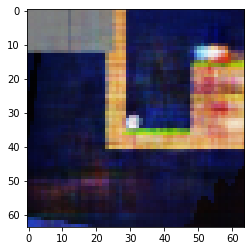

In [43]:
idx = 11
img = dataset[idx][np.newaxis, ...]
img_z = vae.encode(img)
img_z[0,:] += np.random.rand(64) * 4 - 2
img_r = vae.decode(img_z)
plt.imshow(img_r[0])

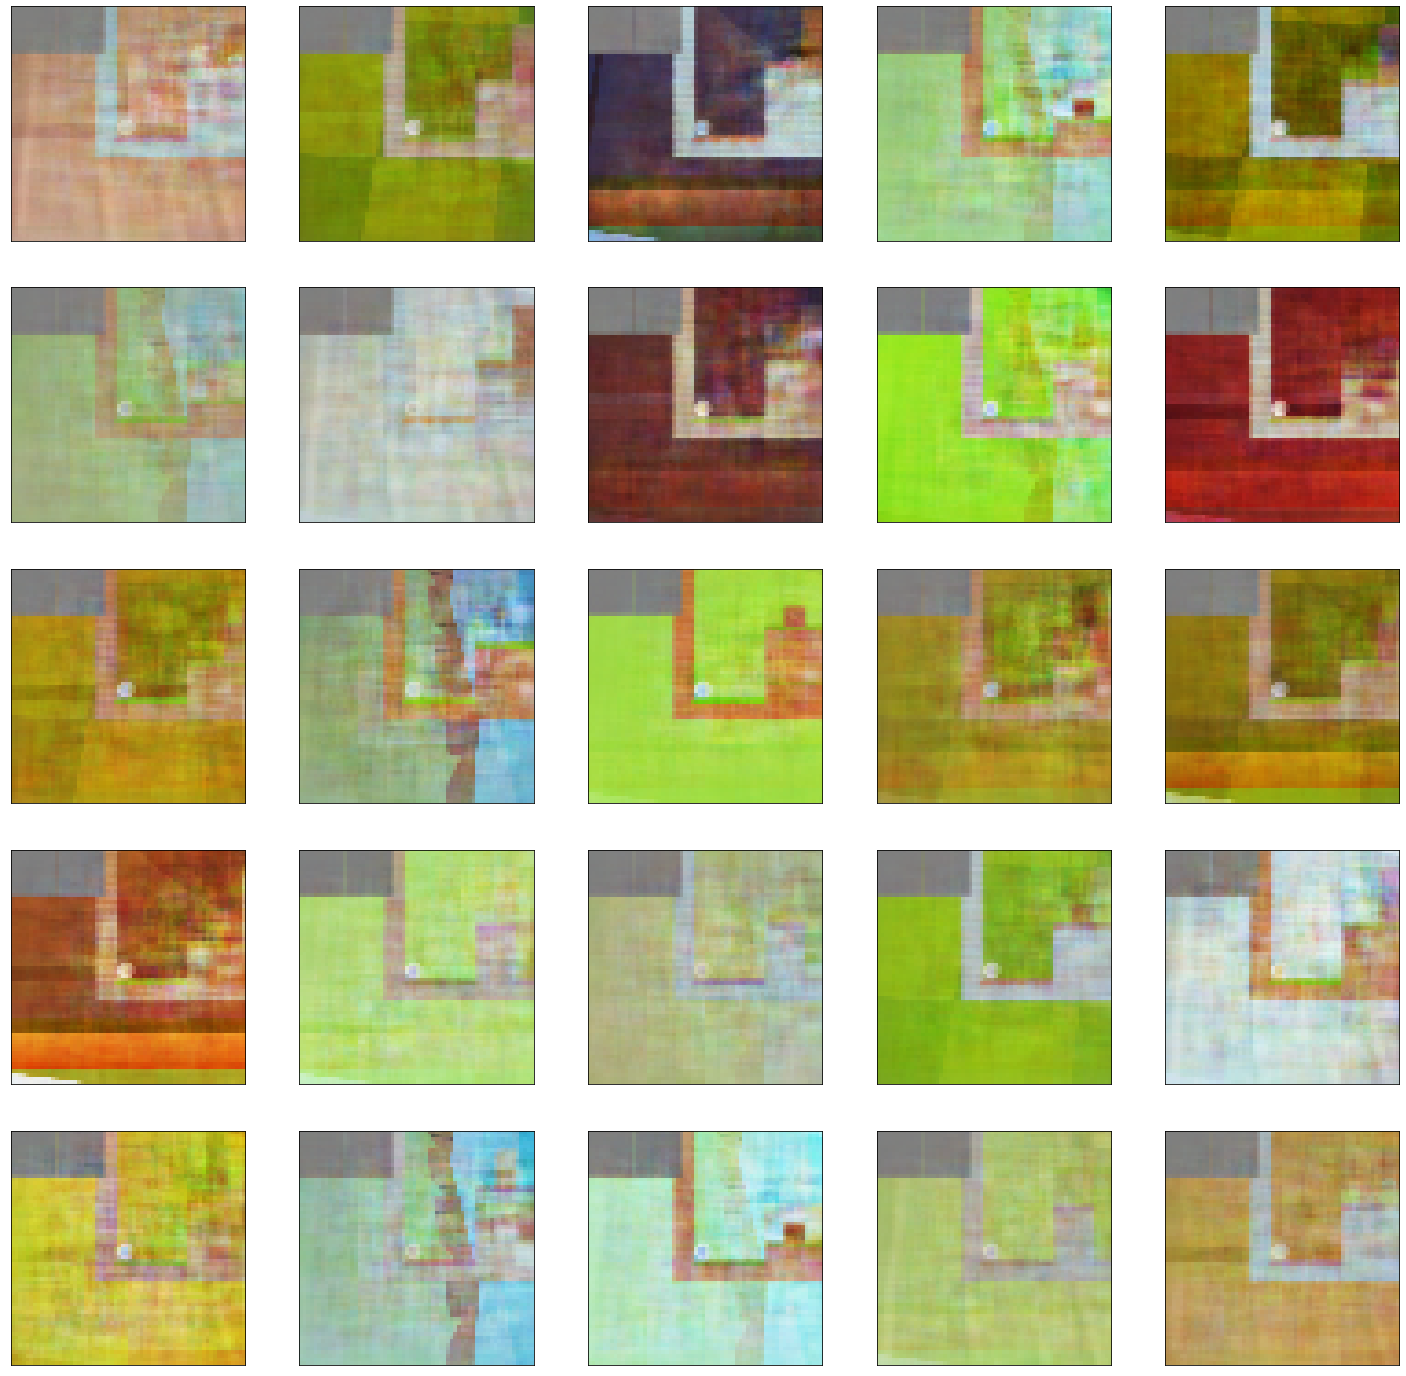

In [76]:
_, axs = plt.subplots(nrows=5, ncols=5, figsize=(25, 25), subplot_kw={'xticks': [], 'yticks': []})

for row in range(5):
    for col in range(5):
        random_z = np.random.rand(1, 64) * 3 - 1.5
        img_r = vae.decode(random_z)
        axs[row][col].imshow(img_r[0])

todo analyze the structure of the z domain
ie values relative to each other for each encoding
so that we have better option than generating them randomly